In [2]:
import numpy as np
import scipy as sp
import pandas as pd

from scipy import optimize

%matplotlib inline 
import matplotlib.pyplot as plt

from simul_functions import S_i_fit

In [3]:
mean_S=[114.64866107858613, 281.263665030094, 434.1710447166398, 569.9988028399946, 687.0546718639996, 780.4870062669543, 864.119024879455, 916.7825679232428, 975.9915880272431, 1022.9939908123263]
rms=[114.74968236197647, 282.01041012696396, 434.47275315291114, 570.8325673130487, 687.4374797608367, 781.6874291625296, 864.5162056661065, 917.0785397347968, 976.4170138865792, 1024.7237580132255]
sigma_S=[4.813950047724185, 20.509074913742488, 16.188797420809703, 30.84128185045552, 22.93831837303278, 43.304387297040904, 26.20268499031733, 23.297450379212293, 28.82022045794128, 59.515334146904]
S_ref_values=[524.36037518,717.49813895,850.49419746, 715.4684653,951.54946654,893.63784202,811.12501887,896.93268679,870.97201082,1003.64425617]

b_true=0.919
a_true=-1.13
c_true=1
sigma_S_ar=np.asarray(sigma_S)

cos=np.linspace(0.05,0.95,10, endpoint = True)
y=S_i_fit(cos,a_true,b_true,S_ref_values)
cos_ref=np.cos(38*np.pi/180.)**2
x = cos-cos_ref


In [4]:
def lnlike(theta, x, y,f,yerr):
    a,b,c=theta
    model = f*(a*x**2 + b*x+c)
    return -0.5*np.sum((y-model)**2/yerr**2 + np.log(yerr**2))

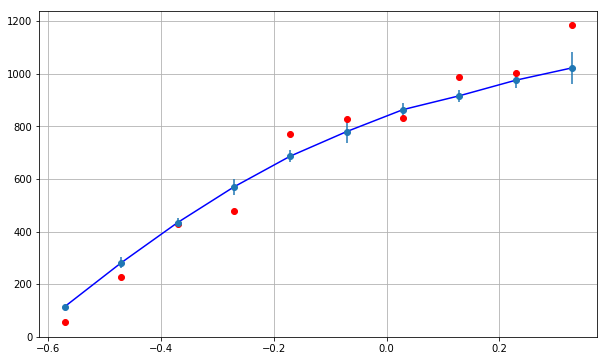

In [9]:
fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
ax2.plot(x,y,'ro',linestyle='None', c='r')
ax2.plot(x, mean_S,c='b')
ax2.plot(x,S_ref_values*(a_true*x**2+b_true*x+c_true),linestyle='None',c='k')
plt.errorbar(x, mean_S, xerr=None, yerr=sigma_S, fmt='o')
plt.show()

In [16]:
import scipy.optimize as op

nll = lambda *args: -lnlike(*args)
x0=[a_true, b_true,c_true]
result= op.minimize(nll, x0, args=(x, y, S_ref_values,sigma_S_ar))
a_ml, b_ml, c_ml= result["x"]

print(result["x"])

[-1.13   0.919  1.   ]


**MCMC**

In [18]:
def lnprior(theta):
    a, b,c = theta
    if -2.0<a<0. and 0.<b<1.5 and 0.<c<1.5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y,f, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y,f,yerr)

In [19]:
ndim, nwalkers =3,100
pos = [result["x"]*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x,y,S_ref_values,sigma_S_ar))

sampler.run_mcmc(pos, 500)

/home/noemie/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/noemie/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[-1.37293473e+00,  8.31281094e-01,  1.01223691e+00],
        [-1.68447810e+00, -1.40531219e+00, -9.38902632e-01],
        [-1.17185591e+00,  8.93861151e-01,  1.00490120e+00],
        [-1.21129910e+00,  8.77714638e-01,  1.00286727e+00],
        [-1.04348280e+00,  9.75024931e-01,  1.00211760e+00],
        [-1.15662176e+00,  9.22075061e-01,  1.01639415e+00],
        [ 2.87935327e+00, -6.14908753e-02, -3.88616960e-02],
        [-1.23350698e+00,  8.68064803e-01,  9.94139641e-01],
        [-1.08124261e+00,  9.14175384e-01,  9.87806486e-01],
        [-6.73419336e-01, -1.19497648e+00, -3.19406514e-01],
        [-1.30811239e+00,  8.54662565e-01,  1.00857393e+00],
        [ 7.27264938e-01,  3.03649636e-01, -2.25143465e+00],
        [-1.24790341e+00,  8.60227574e-01,  9.98155890e-01],
        [-4.67570538e-01, -1.87765743e+00,  1.52959105e+00],
        [-4.57153942e-01,  5.52604458e-01,  5.62144921e-01],
        [ 2.58141916e+00,  7.03713687e-01, -4.08333842e-01],
        [-1.06236620e+00

In [20]:
samples= sampler.chain[:, 50:, :].reshape((-1,ndim))

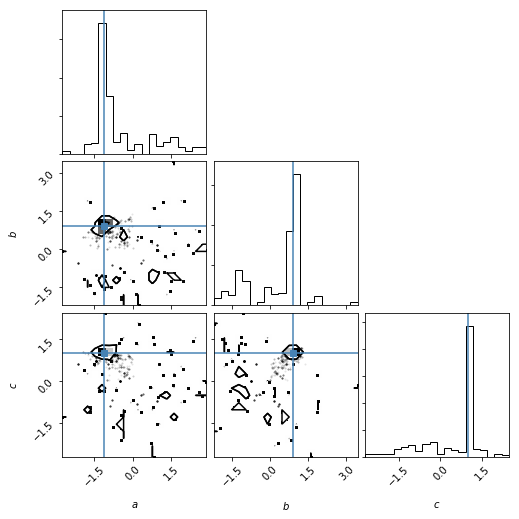

In [21]:
import corner
fig = corner.corner(samples, labels=["$a$","$b$", "$c$"], truths=[a_true,b_true,c_true])
fig.savefig("")

<Container object of 3 artists>

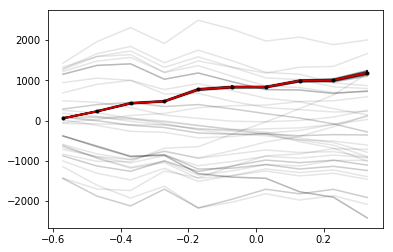

In [22]:

for a, b,c in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(x, S_ref_values*(a*x**2+b*x+c), color="k", alpha=0.1)
plt.plot(x, S_ref_values*(a_true*x**2+b_true*x+c_true), color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=sigma_S_ar, fmt=".k")
